## Interference pattern and effective optical depth modulation

 author : Sylvie Dagoret-Campagne
- aflilation IJCLab/IN2P3/CNRS
- creation date 2025-01-17
- last update : 2025-01-17 : Emulsion formula
- doc on FFT : https://numpy.org/doc/2.0/reference/generated/numpy.fft.fft.html
- conda environnement : poppy_conda_py312 (on my macbook)
- install poppy : https://poppy-optics.readthedocs.io/en/latest/
- install rise in jupyterlab to see the slides : https://github.com/jupyterlab-contrib/rise
- install pandoc for documentation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.integrate import quad
from scipy.signal import periodogram

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.titlesize'] =  22
mpl.rcParams['axes.labelsize'] =  20
mpl.rcParams['lines.markersize'] =  10
mpl.rcParams['xtick.labelsize'] =  16
mpl.rcParams['ytick.labelsize'] = 16

## Introduction

### Diffraction of a parallel beam by a 1D aperture $x_1$ seen on a screen at $x_0$ 

We approximate the diffraction by an optical element with the 1D approximation, with the $x$ axis as the transverse coordinalte and the $z$ axis the wave propagation axis.
Taking the formula from the Goodman book we get the formula:

- in Fresnel approximation (spherical wave $\rightarrow$ quadratic terms in propagation term $\frac{e^{ikr_{01}}}{j\lambda z}$~:$z^3 \gg \frac{\pi}{4\lambda}\left(x_0-x_1\right)^4|_{max} $:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int \left\{ U(x_1) \exp\left(  j \frac{k}{2z}x_1^2\right)\right\} \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- in Fraunhofer approximation $ z \gg \frac{k(x_1^2+y_1)}{2}|_{max}$:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int  U(x_1)  \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- The Fraunhofer approximation solution is proportional to the Fourier transform of $U(x_1)$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- The Fresnel approximation solution is proportional to the Fourier transform of $\left \{ U(x_1) \cdot \exp\left(  j \frac{k}{2z}x_1^2\right) \right\}$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- $ \alpha$ is the incident angle on the focal line  in the $(X-Z)$ plane.

### Transform the parallel beam into a converging beam

- thin lens of focal length $\phi$ with a transmission function (depending on lens depth $\Delta_0$ and refractive index $n$):
$$
U_l(x) = \exp(j k\Delta_0 n) \cdot \exp(-j \frac{k}{2\phi}x^2)
$$
- When a lens (or mirror) transform a parallel beam into a converging beam at the location of an object and have a screen at the focal plane, the $\exp \left(j \frac{k}{2z}x_1^2 \right)$ is compensated by the lens term $\exp(-j \frac{k}{2\phi}x^2)$
- Thus a  converging lens (or mirror) transform a parallel beam Fresnel diffraction into a Fraunhofer diffraction, provided $z=\phi$.
$$
U(x_\phi) = \frac{exp(jk\phi)}{jk\phi} \exp\left(j \frac{k}{2\phi}x_{\phi}^2 \right) \int \int U(x)\cdot P(x) \times \exp 
\left\{ -j \frac{2 \pi}{\lambda \phi}x_\phi x\right\} dx 
$$

### The pupil function of the lens
$$
P(x) = \left\{ \begin{array}{c} 1 \;\; r < D/2 \\ 0 \;\;r > D/2 \end{array} \right.
$$

where $r=|x|$ and $D$ is the lens diameter.

## Function tools

In [3]:
def convert_angle_to_0_2pi_interval(angle):
    new_angle = np.arctan2(np.sin(angle), np.cos(angle))
    new_angle = np.where(new_angle < 0,np.abs(new_angle) + 2 * (np.pi - np.abs(new_angle)),new_angle)
    return new_angle

In [4]:
convert_angle_to_0_2pi_interval(-np.pi/4)

array(5.49778714)

In [5]:
def convert_angle_to_mpi_ppi_interval(angle):
    new_angle = convert_angle_to_0_2pi_interval(angle)
    new_angle = np.where(new_angle > np.pi, new_angle - 2*np.pi,new_angle)

    return new_angle

### Auxtel Configuration

In [6]:
# wavelength in m
wl = 0.55e-6
wl_nm = wl*1e9
# pixel scale
# 10 microns pixel , 105 microns per arcsec
pix_scale = 10.0/105.0 # arcsec per pixel
fov_arcsec = 5.0 # must restrict the FOV in focl plane to avoid aliasing
# diameter in m
D = 1.2
Fnum = 18
# focal length
FL = D*Fnum
# Dccd
Dccd = 180e-3
# beam radius at object positon
beam_radius_m =  D/2/FL*Dccd
beam_radius_mm =  D/2/FL*Dccd*1000

In [7]:
beam_radius_mm

5.0

### Diffraction Pattern

In [8]:
Neff = 150
xmin = -0.05
xmax = 0.05
dxt = xmax-xmin
a = 1/Neff

### Hologram recording

In [9]:
lambda_R = 0.639e-3 #mm
dR = 20.0  # mm
DR = dR/lambda_R/Neff

## Optical depth pattern function

The interference of the two point sources $A,B$ on the hologram emulsion is described
by the following formula
$$
U_{tot} = U_a + U_b = a\frac{e^{ikr_{AM}}}{r_{AM}} + b\frac{e^{ikr_{BM}}}{r_{BM}}
$$
where $a,b$ are the complex amplitudes of the sources at their emission location and the exponential terms $\frac{e^{ikr}}{r}$ describe the outgoing spherical waves.

- If we approximate $\frac{1}{r_{AM}} \simeq \frac{1}{r_{BM}} \simeq \frac{1}{D_R}$,
- We redefine (a,b) by a relative phase shift between the souces $\Delta \psi$ and a relative positive amplitudes (by definition as the phase shift account for negative)
  $\cos \beta, \sin \beta$ such $0 \le \beta \le \frac{\pi}{4}$:
$$
\begin{array}{ccc}
a & = &a_0 \cos \beta e^{-i \frac{\Delta \psi}{2}} \\
b & = & a_0  \sin\beta  e^{i \frac{\Delta \psi}{2}}
\end{array}
$$

Redfining the coordinate in the recording plane $w$ by $x$:

$$
\begin{array}{ccc}
D_{AM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x \\
D_{BM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x 
\end{array}
$$

If we approximate $D_R \gg d_R,l,x$:

$$
\begin{array}{ccc}
D_{AM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x }{2D_R}\\
D_{BM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x }{2D_R}
\end{array}
$$


### Pattern recorded on emulsion

$$
I = \| U_{tot} \|^2 \propto 1 +  \sin 2\beta \cdot \cos \left( k\frac{d_R\cdot x}{D_R}  -  \Delta \psi \right) =  1 +  \sin 2\beta \cdot \cos \left( 2\pi \frac{d_R\cdot x}{\lambda_F D_R}  -  \Delta \psi \right) 
$$

The periodicity is:

$$
\Delta x = \frac{\lambda_R D_R}{d_R}
$$

and the interference contrast $0 <C< 1$ is :

$ C = \frac{I_{max} - I_{min}}{I_{max} + I_{min}} = \sin 2\beta$

- Note if the two sources have the same amplitudes within a phase shift the contrast is maximal.

In [10]:
def set_beam_aperture(x,radius = beam_radius_mm):
    """
    """
    a = np.where(np.logical_or(x<-radius,x>radius),0.,1.)
    return a

In [11]:
def set_holo_pattern_debug(x,opticalelement_nblines_permm=Neff,xshift=0,contrast=0.5):
    """
    Generate a square pattern of transmission.
    x in mm
    xshift : between -1,1
    contrast : 
    """
    a = 1/opticalelement_nblines_permm
    x = (x + xshift*a/2)/a
    y = (1+contrast*np.cos(2*np.pi*x))/2.
    return y

(0.0, 1.0)

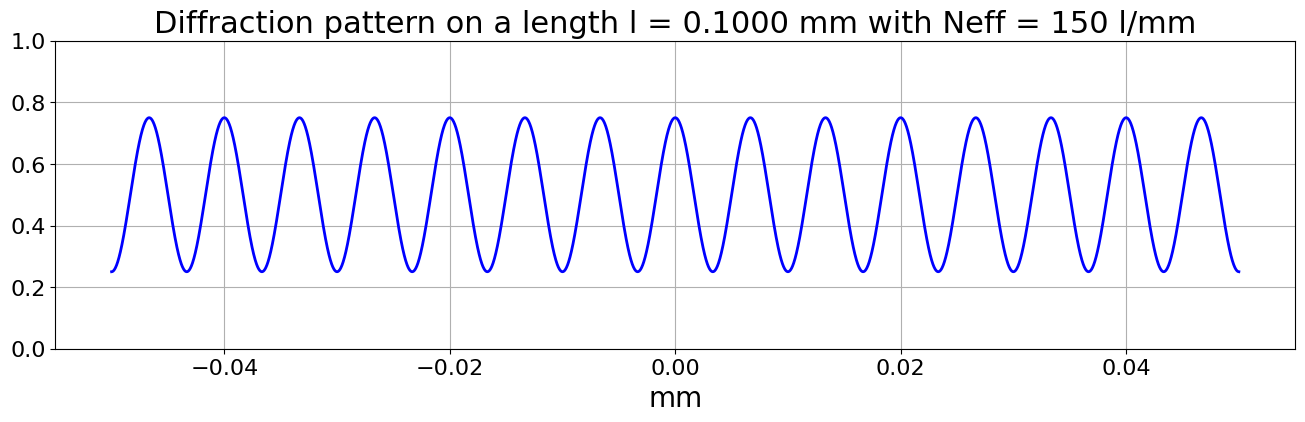

In [12]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = np.linspace(-.05,0.05,5000)
y = set_holo_pattern_debug(x,xshift=0)
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Diffraction pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax.set_xlabel("mm")
ax.set_ylim(0.,1.)

## Calculation of interference patterns

### 1) Definition of the full true interference pattern

In [13]:
def D_AM(x,y):
    """
    Distance in mm between A source and M point on emulsion
    """
    R2 = DR**2 +(dR/2.)**2+y**2 + dR*x
    return np.sqrt(R2)

In [14]:
def D_BM(x,y):
    """
    Distance in mm between B source and M point on emulsion
    """
    R2 = DR**2 +(dR/2.)**2+y**2 - dR*x
    return np.sqrt(R2)

$$
U_{tot} = U_a + U_b = D_R\left( a\frac{e^{ikr_{AM}}}{r_{AM}} + b\frac{e^{ikr_{BM}}}{r_{BM}} \right)
$$

In [15]:
def InterferenceModule1(x,y,C=1,DPsi=0):
    """
    
    True inteferene pattern
    """
    
    # compute real positive amplitude from contrast
    
    cos_beta = np.sqrt((np.sqrt(1-C**2)+1)/2.)   
    sin_beta = np.sqrt((1-np.sqrt(1-C**2))/2.)    
    k_R = 2.*np.pi/lambda_R
    RAM = D_AM(x,y)
    RBM = D_BM(x,y)
    
    Ua = cos_beta*np.exp(1j*DPsi/2)*np.exp(1j*k_R*RAM)/RAM*DR
    Ub = sin_beta*np.exp(1j*DPsi/2)*np.exp(1j*k_R*RBM)/RBM*DR
    
    U = Ua+Ub
    Umod2 = np.abs(U)**2
    return Umod2/2

### 2) Definition of the partiel interference pattern

$$
U_{tot} = U_a + U_b = a\cdot e^{ikr_{AM}} + b\cdot e^{ikr_{BM}}
$$

In [16]:
def InterferenceModule2(x,y,C=1,DPsi=0):
    """  
    Simplified inteferene pattern with no dependence in denominator
    """
    
    # compute real positive amplitude from contrast
    
    cos_beta = np.sqrt((np.sqrt(1-C**2)+1)/2.)   
    sin_beta = np.sqrt((1-np.sqrt(1-C**2))/2.)    
    k_R = 2.*np.pi/lambda_R
    RAM = D_AM(x,y)
    RBM = D_BM(x,y)
    
    Ua = cos_beta*np.exp(1j*DPsi/2)*np.exp(1j*k_R*RAM)
    Ub = sin_beta*np.exp(1j*DPsi/2)*np.exp(1j*k_R*RBM)
    
    U = Ua+Ub
    Umod2 = np.abs(U)**2
    return Umod2/2

### 3) Definition of the simplified interference pattern

$$
I = \| U_{tot} \|^2 \propto 1 +  \sin 2\beta \cdot \cos \left( k\frac{d_R\cdot x}{D_R}  -  \Delta \psi \right) =  1 +  \sin 2\beta \cdot \cos \left( 2\pi \frac{d_R\cdot x}{\lambda_F D_R}  -  \Delta \psi \right) 
$$

In [17]:
def InterferenceModule1D_3(x,C=0.5,DPsi=0):
    """
    Ultra simplifid 
    """
    cos_beta = np.sqrt((np.sqrt(1-C**2)+1)/2.)   
    sin_beta = np.sqrt((1-np.sqrt(1-C**2))/2.)    
    k_R = 2.*np.pi/lambda_R
    
    I = (1+C*np.cos(k_R*dR*x/DR -DPsi))/2.
    return I

In [18]:
def InterferenceModule1D_1(x,C=0.5,DPsi=0):
    return InterferenceModule1(x,0.,C=C,DPsi=DPsi)
def InterferenceModule1D_2(x,C=0.5,DPsi=0):
    return InterferenceModule2(x,0.,C=C,DPsi=DPsi)    

### Shift the origin of the pattern 

In [19]:
FLAG_ORIGIN_OF_PATTERN_SOURCEA = True

In [20]:
if FLAG_ORIGIN_OF_PATTERN_SOURCEA:

    def InterferenceModule1D_1_A(x,C=0.5,DPsi=0):
        return InterferenceModule1D_1((x+dR/2),C=C,DPsi=DPsi)
    def InterferenceModule1D_2_A(x,C=0.5,DPsi=0):
        return InterferenceModule1D_2((x+dR/2),C=C,DPsi=DPsi)
    def InterferenceModule1D_3_A(x,C=0.5,DPsi=0):
        return InterferenceModule1D_3((x+dR/2),C=C,DPsi=DPsi)
else:
    def InterferenceModule1D_1_A(x,C=0.5,DPsi=0):
        return InterferenceModule1D_1(x,C=C,DPsi=DPsi)
    def InterferenceModule1D_2_A(x,C=0.5,DPsi=0):
        return InterferenceModule1D_2(x,C=C,DPsi=DPsi)
    def InterferenceModule1D_3_A(x,C=0.5,DPsi=0):
        return InterferenceModule1D_3(x+dR,C=C,DPsi=DPsi)

## Plot Interference pattern and differences

In [21]:
# Beam contrast
C=0.9
# Phase shift
DPSI = 0

### Interference on 100 microns

In [22]:
NPOINTS = 10000
x = np.linspace(-.05,0.05,NPOINTS) 
dx = np.diff(x).mean()

(-0.1, 1.1)

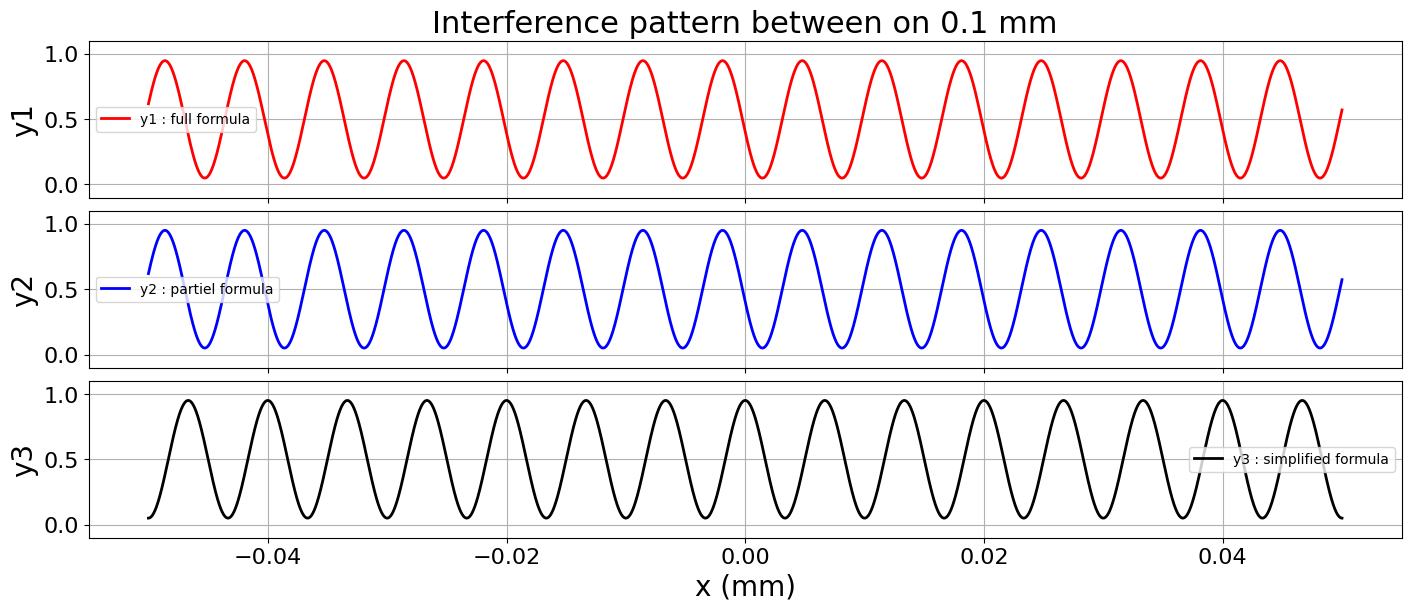

In [23]:
y1 = InterferenceModule1D_1_A(x,C,DPSI) 
y2 = InterferenceModule1D_2_A(x,C,DPSI) 
y3 = InterferenceModule1D_3_A(x,C,DPSI)

fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(14,6),layout="constrained",sharex=True,sharey=True)
ax1.plot(x,y1,'-r',label = "y1 : full formula")
ax2.plot(x,y2,'b',label = "y2 : partiel formula")
ax3.plot(x,y3,'k',label = "y3 : simplified formula")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()


ax1.set_title("Interference pattern between on 0.1 mm")
ax3.set_xlabel("x (mm)")
ax1.set_ylabel("y1")
ax2.set_ylabel("y2")
ax3.set_ylabel("y3")
ax1.set_ylim(-0.1,1.1)

Text(0, 0.5, 'y1-y2')

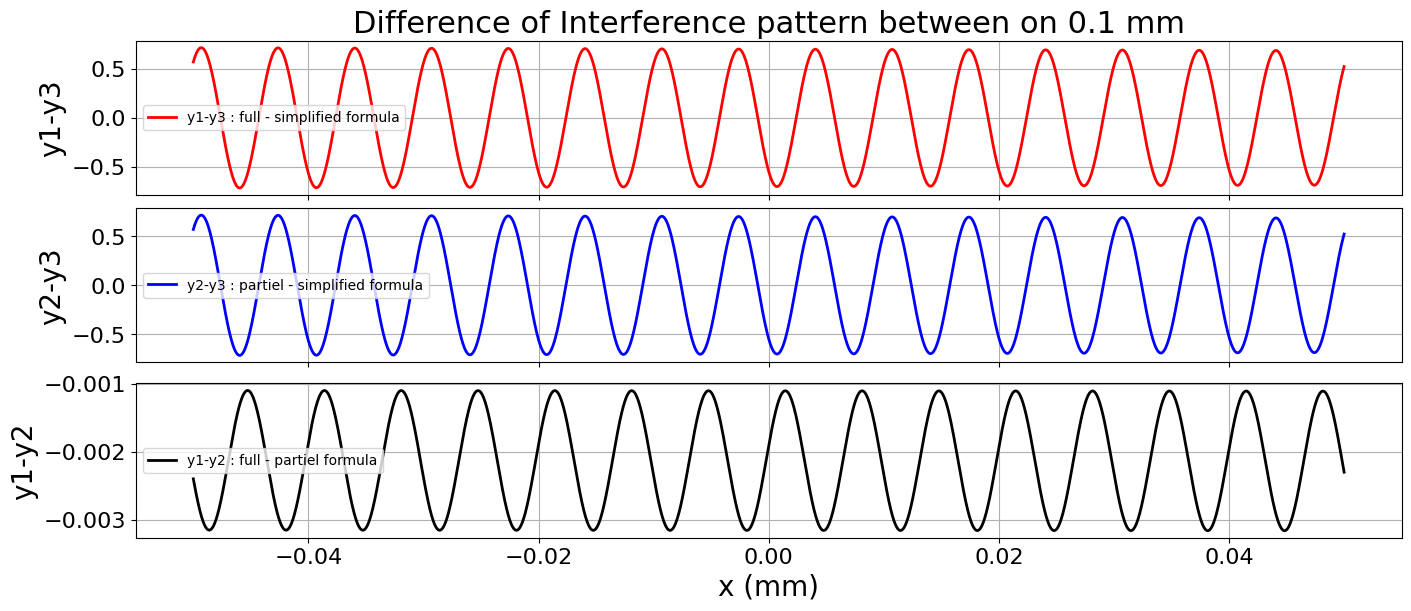

In [24]:
y1 = InterferenceModule1D_1_A(x,C,DPSI) 
y2 = InterferenceModule1D_2_A(x,C,DPSI) 
y3 = InterferenceModule1D_3_A(x,C,DPSI)

fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(14,6),layout="constrained",sharex=True)
ax1.plot(x,y1-y3,'r',label = "y1-y3 : full - simplified formula")
ax2.plot(x,y2-y3,'b',label = "y2-y3 : partiel - simplified formula")
ax3.plot(x,y1-y2,'k',label = "y1-y2 : full - partiel formula")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()

ax1.set_title("Difference of Interference pattern between on 0.1 mm")
ax3.set_xlabel("x (mm)")
ax1.set_ylabel("y1-y3")
ax2.set_ylabel("y2-y3")
ax3.set_ylabel("y1-y2")

### Interference on 1 micron

In [25]:
NPOINTS = 10000
x = np.linspace(-.5,0.5,NPOINTS) 
dx = np.diff(x).mean()

(-0.1, 1.1)

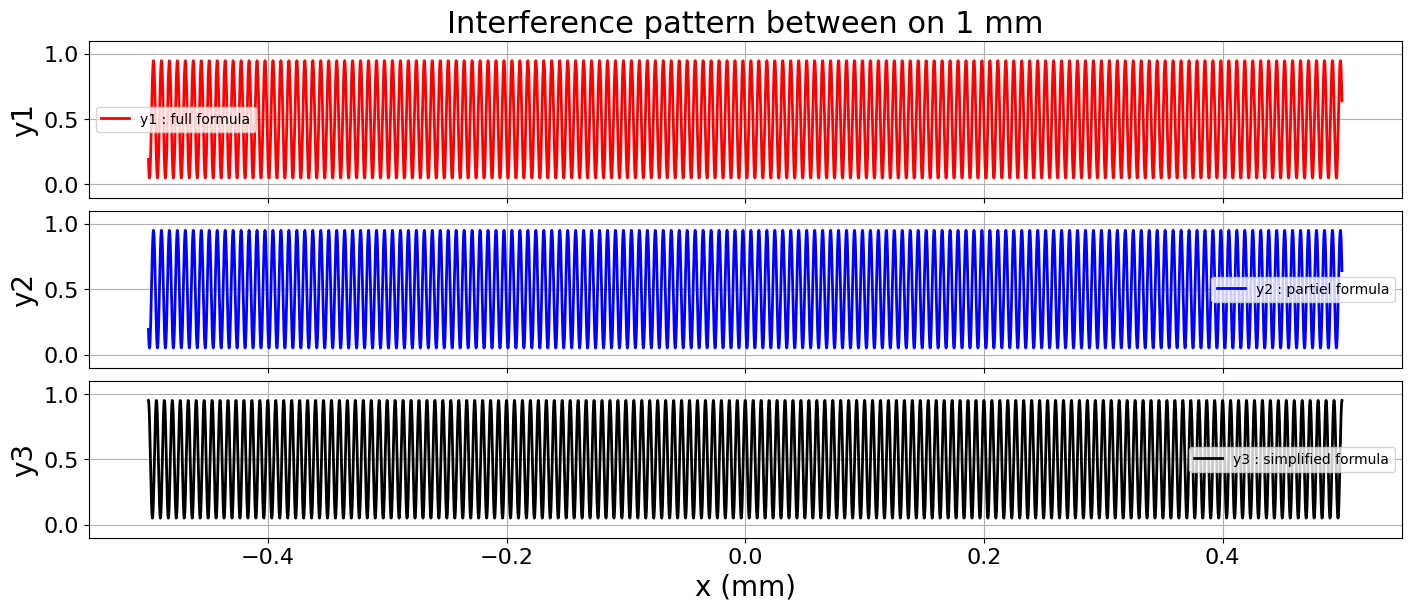

In [26]:
y1 = InterferenceModule1D_1_A(x,C,DPSI) 
y2 = InterferenceModule1D_2_A(x,C,DPSI) 
y3 = InterferenceModule1D_3_A(x,C,DPSI)


fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(14,6),layout="constrained",sharex=True,sharey=True)
ax1.plot(x,y1,'r',label = "y1 : full formula")
ax2.plot(x,y2,'b',label = "y2 : partiel formula")
ax3.plot(x,y3,'k',label = "y3 : simplified formula")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()

ax1.set_ylabel("y1")
ax2.set_ylabel("y2")
ax3.set_ylabel("y3")
ax1.set_title("Interference pattern between on 1 mm")
ax3.set_xlabel("x (mm)")

ax1.set_ylim(-0.1,1.1)

Text(0, 0.5, 'y1-y2')

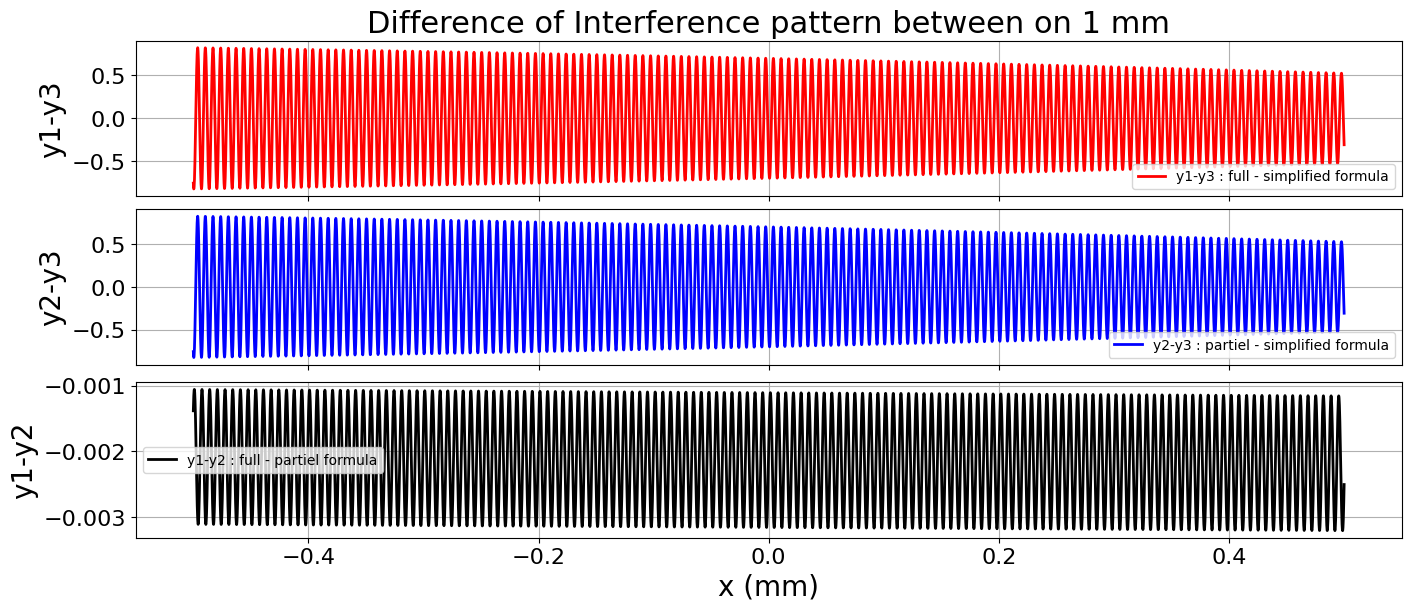

In [27]:
y1 = InterferenceModule1D_1_A(x,C,DPSI) 
y2 = InterferenceModule1D_2_A(x,C,DPSI) 
y3 = InterferenceModule1D_3_A(x,C,DPSI)

fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(14,6),layout="constrained",sharex=True)
ax1.plot(x,y1-y3,'r',label = "y1-y3 : full - simplified formula")
ax2.plot(x,y2-y3,'b',label = "y2-y3 : partiel - simplified formula")
ax3.plot(x,y1-y2,'k',label = "y1-y2 : full - partiel formula")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()


ax1.set_title("Difference of Interference pattern between on 1 mm")
ax3.set_xlabel("x (mm)")
ax1.set_ylabel("y1-y3")
ax2.set_ylabel("y2-y3")
ax3.set_ylabel("y1-y2")

### Interference on 10 mm (beam size)

In [28]:
NPOINTS = 20000
x = np.linspace(-5.,5.,NPOINTS) 
dx = np.diff(x).mean()

(-0.1, 1.1)

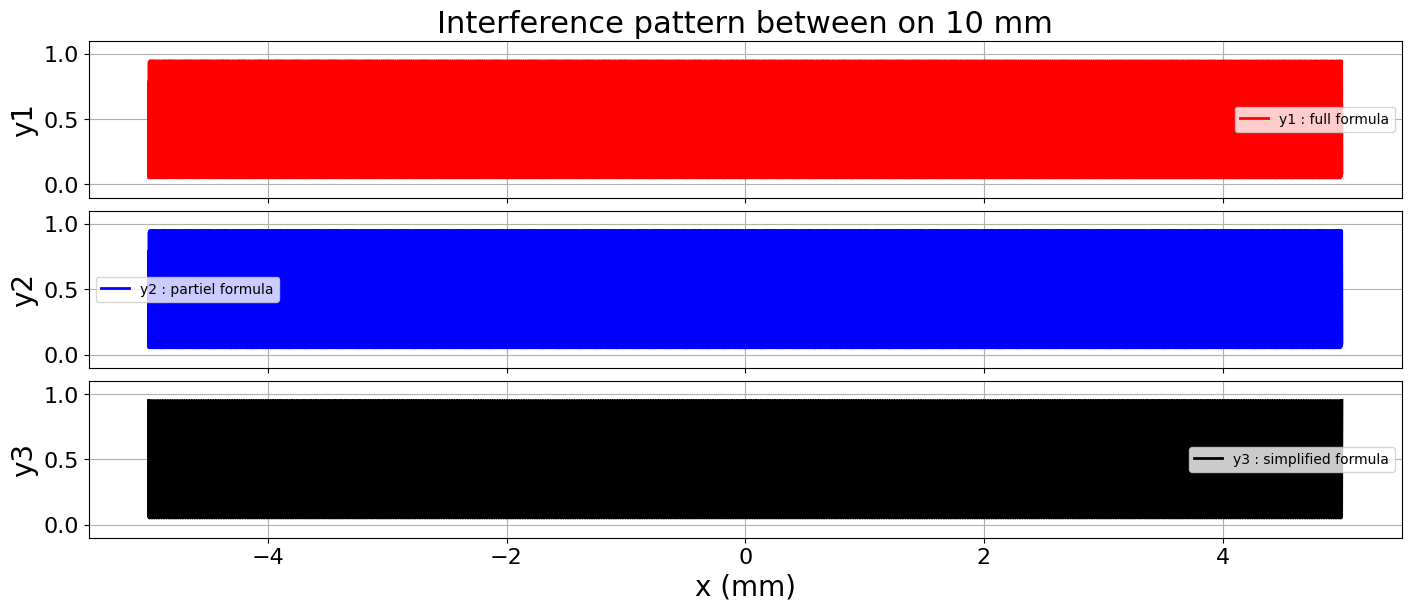

In [29]:
y1 = InterferenceModule1D_1_A(x,C,DPSI) 
y2 = InterferenceModule1D_2_A(x,C,DPSI) 
y3 = InterferenceModule1D_3_A(x,C,DPSI)


fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(14,6),layout="constrained",sharex=True,sharey=True)
ax1.plot(x,y1,'r',label = "y1 : full formula")
ax2.plot(x,y2,'b',label = "y2 : partiel formula")
ax3.plot(x,y3,'k',label = "y3 : simplified formula")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
ax1.set_ylabel("y1")
ax2.set_ylabel("y2")
ax3.set_ylabel("y3")
ax1.set_title("Interference pattern between on 10 mm")
ax3.set_xlabel("x (mm)")

ax1.set_ylim(-0.1,1.1)

Text(0, 0.5, 'y1-y2')

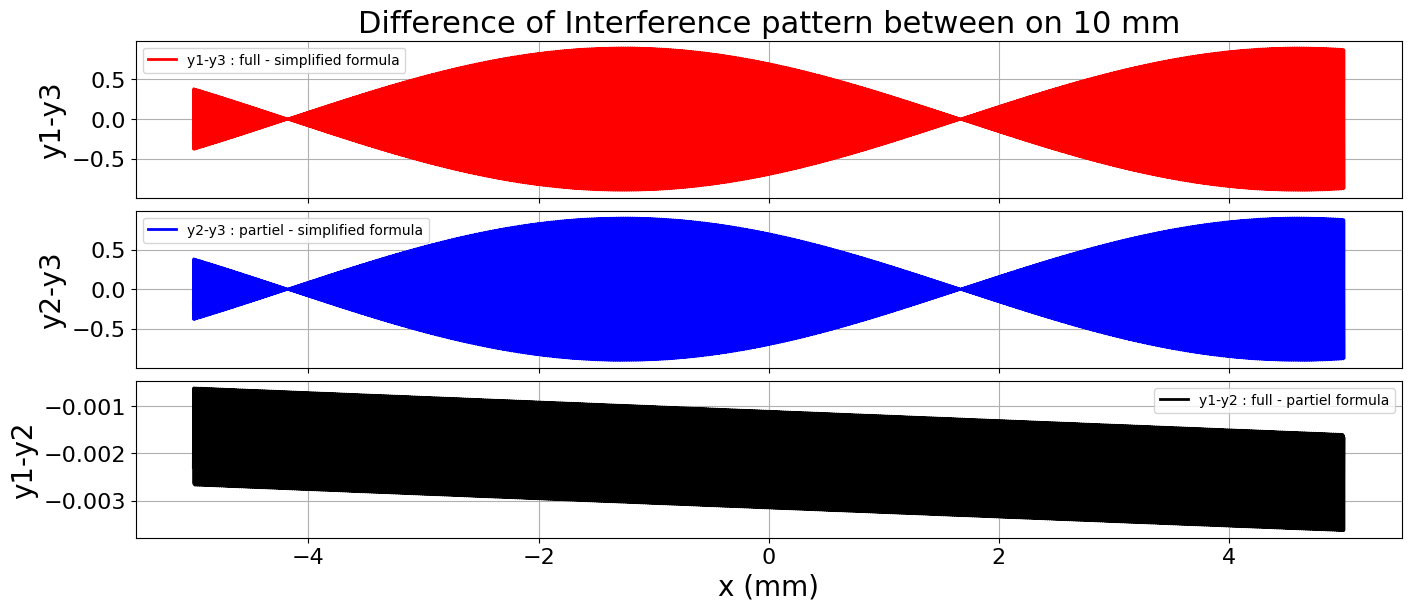

In [30]:
y1 = InterferenceModule1D_1_A(x,C,DPSI) 
y2 = InterferenceModule1D_2_A(x,C,DPSI) 
y3 = InterferenceModule1D_3_A(x,C,DPSI)

fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(14,6),layout="constrained",sharex=True)
ax1.plot(x,y1-y3,'r',label = "y1-y3 : full - simplified formula")
ax2.plot(x,y2-y3,'b',label = "y2-y3 : partiel - simplified formula")
ax3.plot(x,y1-y2,'k',label = "y1-y2 : full - partiel formula")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()


ax1.set_title("Difference of Interference pattern between on 10 mm")
ax3.set_xlabel("x (mm)")
ax1.set_ylabel("y1-y3")
ax2.set_ylabel("y2-y3")
ax3.set_ylabel("y1-y2")

## Periodogram

In [31]:
fp1, Pxx_den1 = periodogram(y1, fs=1/dx)
fp2, Pxx_den2 = periodogram(y2, fs=1/dx)
fp3, Pxx_den3 = periodogram(y3, fs=1/dx)

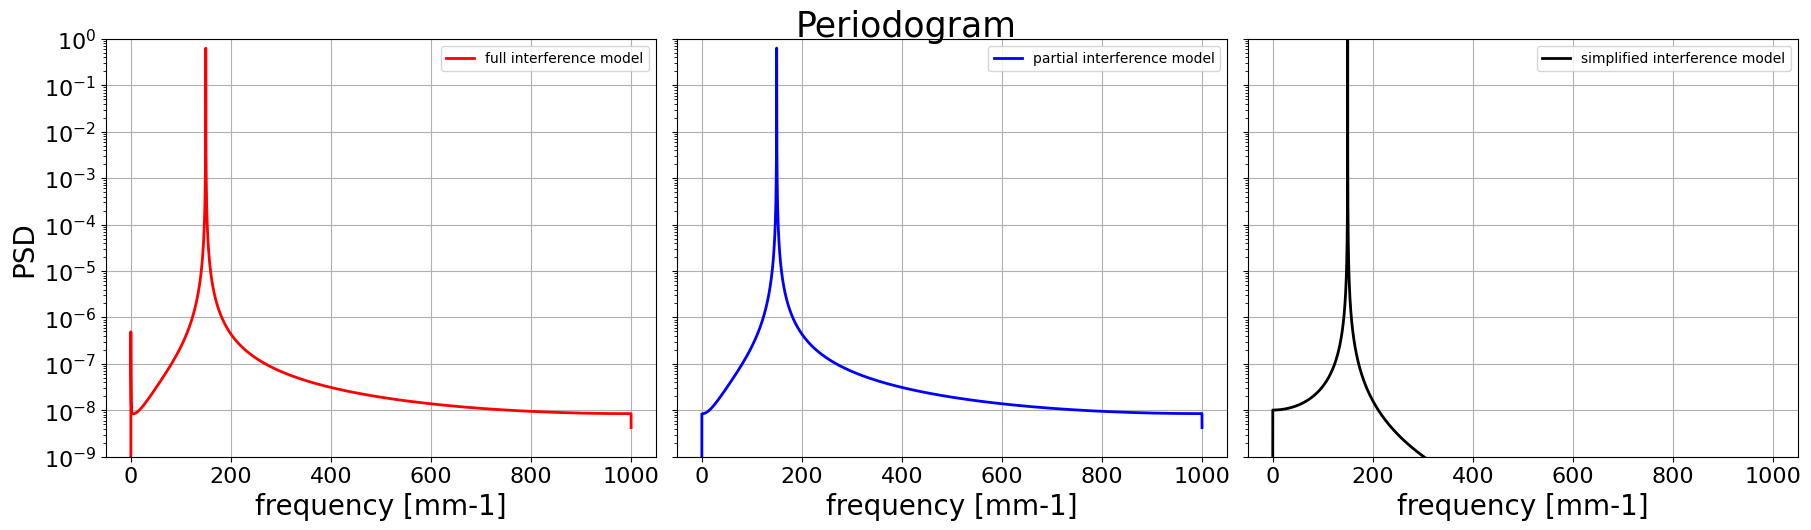

In [56]:
fig,axs = plt.subplots(1,3,figsize=(18,5),layout="constrained",sharex=True,sharey=True)
ax1,ax2,ax3 = axs.flatten()

ax1.semilogy(fp1, Pxx_den1,"r-",label="full interference model")
ax1.set_ylim([1e-9, 1e0])

ax2.semilogy(fp2, Pxx_den2,"b-",label="partial interference model")
ax2.set_ylim([1e-9, 1e0])

ax3.semilogy(fp3, Pxx_den3,"k-",label="simplified interference model")
ax3.set_ylim([1e-9, 1e0])

ax1.set_xlabel('frequency [mm-1]')
ax2.set_xlabel('frequency [mm-1]')
ax3.set_xlabel('frequency [mm-1]')
ax1.grid()
ax2.grid()
ax3.grid()
ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_ylabel('PSD')
plt.suptitle("Periodogram",y=1.03,fontsize=25)
plt.show()

## Optical depth

- Perhaps should change the name because it is homogenous to an optical length

$$
\Delta (E_{rec}(x,\lambda_R)) = \frac{\Delta_{max}(\lambda_R) }{ 1 + \exp\{ -\gamma\left(\frac{E_{rec}(x)-E_0 }{E_0}\right)\}}
$$

In [33]:
thegamma = 6.5
deltamax = 550 # nm
delta_erec = lambda erec : deltamax/(1+np.exp(-thegamma*(erec-1))) 

In [34]:
e = np.linspace(0,3)
der = delta_erec(e)

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_34561/4176660645.py:4: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel("$\Delta(E_{rec}/E_0)$ (nm)")


Text(0.5, 1.0, 'Optical path supp vs energy deposit')

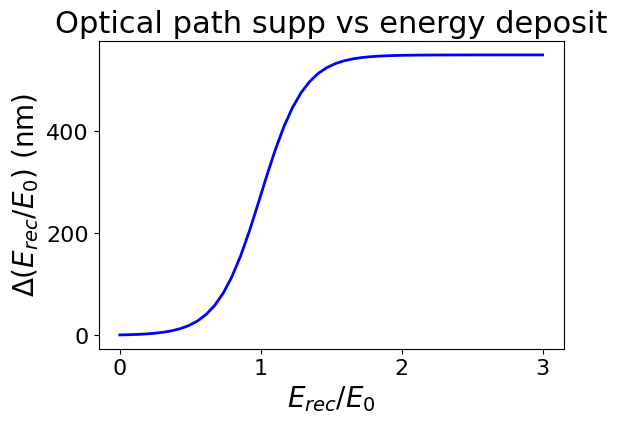

In [35]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(e,der,'-b')
ax.set_xlabel("$E_{rec}/E_0$")
ax.set_ylabel("$\Delta(E_{rec}/E_0)$ (nm)")
ax.set_title("Optical path supp vs energy deposit")

### Transmission
$$
t(x,\lambda) = \exp\left\{i 2\pi \frac{\Delta E_{rec}(x,\lambda_R)}{\lambda}\right\}
$$

In [36]:
def Holo_Phase_1A(x):
    """
    """
    return 2.*np.pi/wl_nm*delta_erec(InterferenceModule1D_1_A(x,C,DPSI))  
def Holo_Phase_2A(x):
    """
    """
    return 2.*np.pi/wl_nm*delta_erec(InterferenceModule1D_2_A(x,C,DPSI))
def Holo_Phase_3A(x):
    """
    """
    return 2.*np.pi/wl_nm*delta_erec(InterferenceModule1D_3_A(x,C,DPSI))

In [37]:
NPOINTS = 10000
x = np.linspace(-.05,0.05,NPOINTS) 
delta_x = x.max()-x.min()
dx = np.diff(x).mean()
y_holo_ph_1A = Holo_Phase_1A(x)
y_holo_ph_2A = Holo_Phase_2A(x)
y_holo_ph_3A = Holo_Phase_3A(x)

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_34561/1079263066.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel("$\phi(x)$")


Text(0.5, 1.0, 'Hologram phase modulation over 0.1 mm')

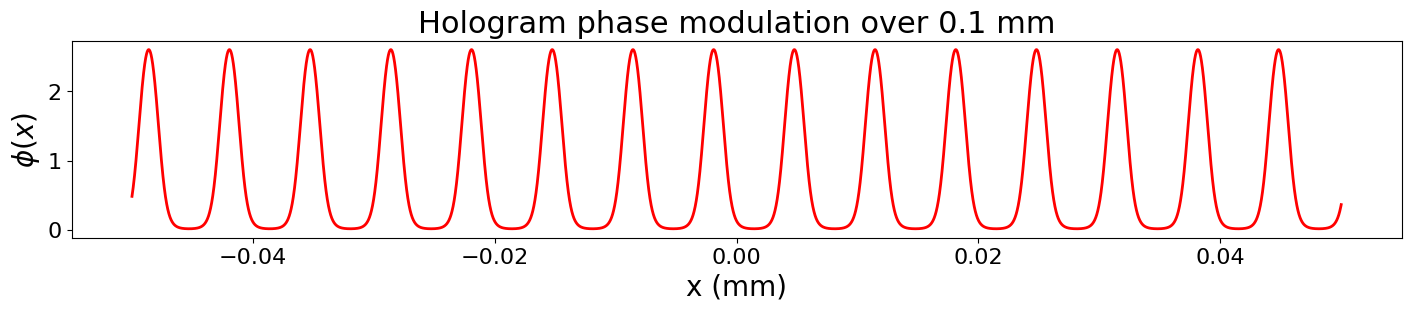

In [38]:
fig,ax  = plt.subplots(1,1,figsize=(14,3),layout="constrained",sharex=True)
ax.plot(x,y_holo_ph_1A,'-r',label = "hologram phase : full - simplified formula")
ax.set_xlabel("x (mm)")
ax.set_ylabel("$\phi(x)$")
ax.set_title(f"Hologram phase modulation over {delta_x} mm")

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_34561/1637378656.py:12: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel("$\phi(x)$")


Text(0.5, 1.0, 'Hologram phase modulation over 1.0 mm')

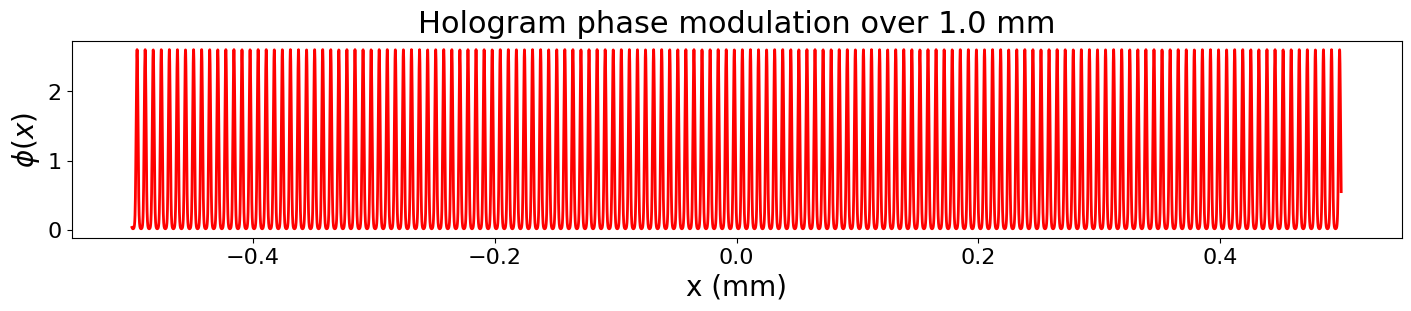

In [39]:
NPOINTS = 10000
x = np.linspace(-.5,0.5,NPOINTS) 
delta_x = x.max()-x.min()
dx = np.diff(x).mean()
y_holo_ph_1A = Holo_Phase_1A(x)
y_holo_ph_2A = Holo_Phase_2A(x)
y_holo_ph_3A = Holo_Phase_3A(x)

fig,ax  = plt.subplots(1,1,figsize=(14,3),layout="constrained",sharex=True)
ax.plot(x,y_holo_ph_1A,'-r',label = "hologram phase : full - simplified formula")
ax.set_xlabel("x (mm)")
ax.set_ylabel("$\phi(x)$")
ax.set_title(f"Hologram phase modulation over {delta_x} mm")

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_34561/3685127243.py:14: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel("$\phi(x)$")


Text(0.5, 1.0, 'Hologram phase modulation over 10.0 mm')

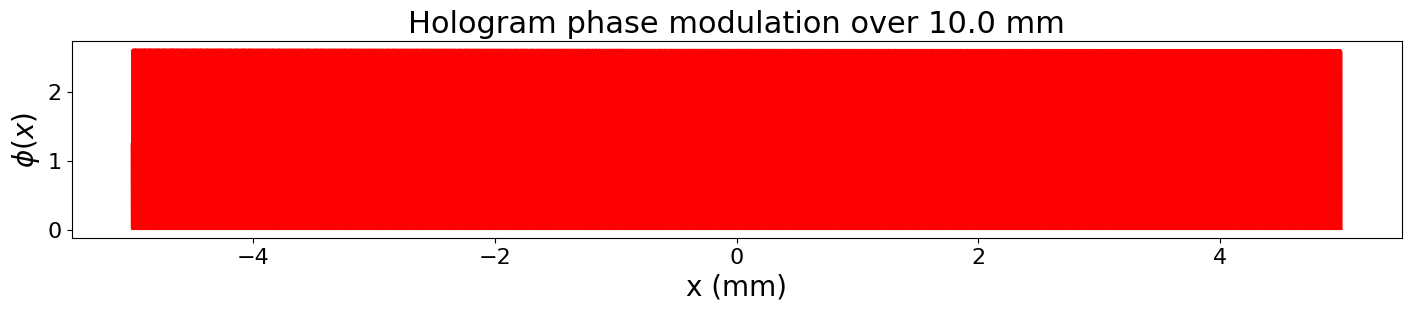

In [40]:
NPOINTS = 50000
x = np.linspace(-5.0,5.0,NPOINTS) 
delta_x = x.max()-x.min()
dx = np.diff(x).mean()

y_holo_ph_1A = Holo_Phase_1A(x)
y_holo_ph_2A = Holo_Phase_2A(x)
y_holo_ph_3A = Holo_Phase_3A(x)


fig,ax  = plt.subplots(1,1,figsize=(14,3),layout="constrained",sharex=True)
ax.plot(x,y_holo_ph_1A,'-r',label = "hologram phase : full - simplified formula")
ax.set_xlabel("x (mm)")
ax.set_ylabel("$\phi(x)$")
ax.set_title(f"Hologram phase modulation over {delta_x} mm")

In [41]:
fpe_1A, Pxx_dene_1A = periodogram(y_holo_ph_1A, fs=1/dx)
fpe_2A, Pxx_dene_2A = periodogram(y_holo_ph_2A, fs=1/dx)
fpe_3A, Pxx_dene_3A = periodogram(y_holo_ph_3A, fs=1/dx)

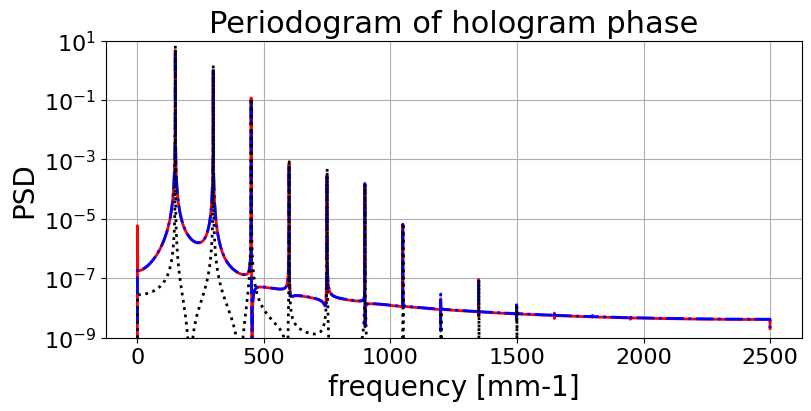

In [44]:
fig,ax = plt.subplots(1,1,figsize=(8,4),layout="constrained",sharex=True)

ax.semilogy(fpe_1A, Pxx_dene_1A,"r-")
ax.semilogy(fpe_2A, Pxx_dene_2A,"b-.")
ax.semilogy(fpe_3A, Pxx_dene_3A,"k:")
ax.set_ylim([1e-9, 1e1])
ax.set_xlabel('frequency [mm-1]')
ax.set_ylabel('PSD')
ax.grid()
ax.set_title("Periodogram of hologram phase")
plt.show()

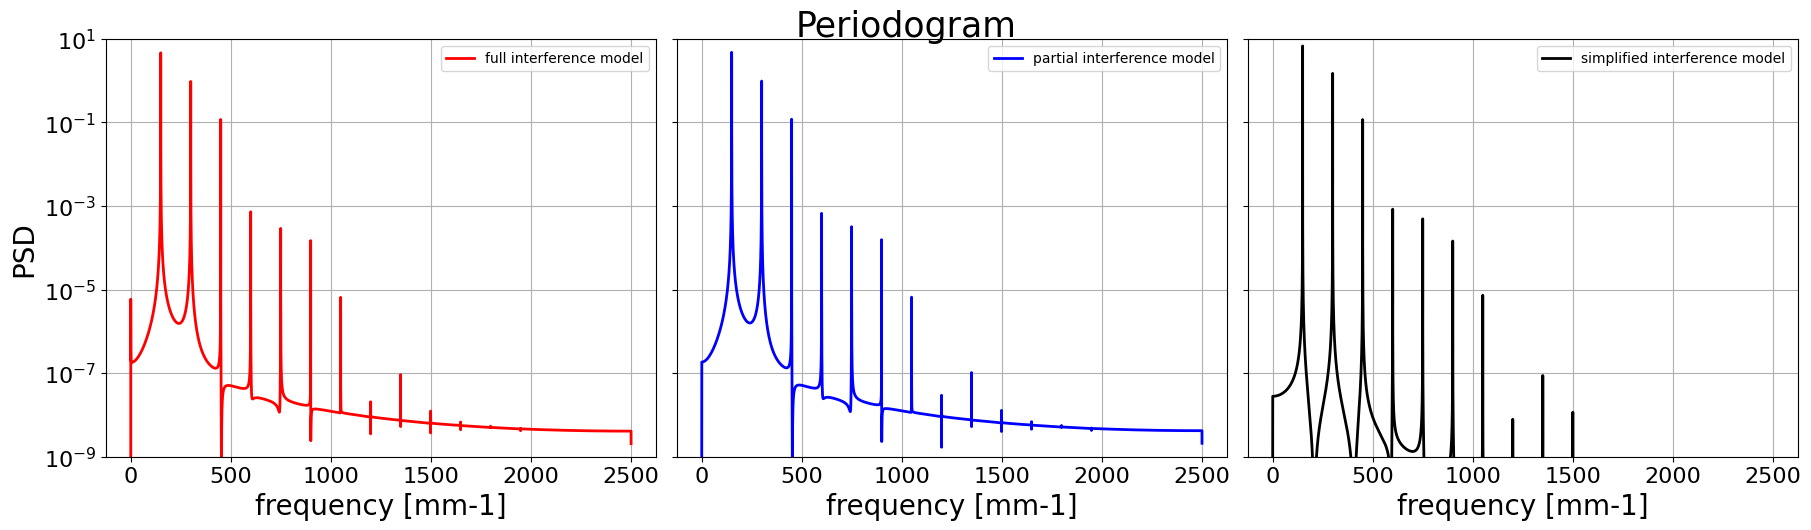

In [55]:
fig,axs = plt.subplots(1,3,figsize=(18,5),layout="constrained",sharex=True,sharey=True)
ax1,ax2,ax3 = axs.flatten()


ax1.semilogy(fpe_1A, Pxx_dene_1A,"r-",label="full interference model")
ax1.set_ylim([1e-9, 1e1])

ax2.semilogy(fpe_2A, Pxx_dene_2A,"b-",label="partial interference model")
ax2.set_ylim([1e-9, 1e1])

ax3.semilogy(fpe_3A, Pxx_dene_3A,"k-",label="simplified interference model")
ax3.set_ylim([1e-9, 1e1])

ax1.set_xlabel('frequency [mm-1]')
ax2.set_xlabel('frequency [mm-1]')
ax3.set_xlabel('frequency [mm-1]')
ax1.grid()
ax2.grid()
ax3.grid()

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_ylabel('PSD')
plt.suptitle("Periodogram",y=1.03,fontsize=25)
plt.show()

- thus the non-linearity in the exponential introduces harmonics 